In [1]:
from dewan_calcium.helpers import DewanIOhandler
DewanIOhandler.create_project_framework('HF-FM')

In [2]:
%load_ext autoreload
%autoreload 2

In [24]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import trange, tqdm

from dewan_calcium import DewanManualCuration, DewanDeconv
from dewan_calcium.helpers import DewanIOhandler

In [4]:
animal = 'ANIMAL_GOES_HERE'
date = 'DATE_GOES_HERE'

fileHeader = animal + '-' + date + '-'

In [6]:
#STEP 2A.1: LOAD ALL DATA
# Read in data for processing.  Needs Cell Traces, and GPIO file.
folder_path = Path(*['HF_FM_Analysis','RawData'])
CellTraceData = pd.read_csv(folder_path.joinpath('CellTraces.csv'), engine='pyarrow')
GPIOData = pd.read_csv(folder_path.joinpath('GPIO.csv'), header=None, engine='pyarrow')
AllCellProps = pd.read_csv(folder_path.joinpath('Props.csv'), header=0, engine='pyarrow') # header = 0 because row 0 has all the property names
CellKeys, CellOutlines = DewanIOhandler.get_outline_coordinates(folder_path.joinpath('Cell_Contours.json')) # Load cell outlines from JSON file
MaxProjectionImagePath = folder_path.joinpath('Max_Projection.tiff') # Create path for Max Projection image for later

In [7]:
# STEP 2A.2: PREPROCESSING

# STEP 2A.2.1: Drop the first row which contains all 'undecided' labels which is the Inscopix default label.
CellTraceData.drop([0], inplace=True)

# STEP 2A.2.2: Force all dF/F values to be numbers and round times to 2 decimal places
CellTraceData = CellTraceData.apply(pd.to_numeric, errors='coerce')
# Set the times as the index so the listed data is all dF/F values
CellTraceData[CellTraceData.columns[0]] = CellTraceData[CellTraceData.columns[0]].round(2)
CellTraceData.set_index(CellTraceData.columns[0], inplace=True)

# STEP 2A.2.3: Remove spaces from column names
CellTraceData.columns = [key.replace(' ', '') for key in CellTraceData.columns.values]

# STEP 2A.2.4: REMOVE ALL MULTI-COMPONENT CELLS
# Generate a list of cell numbers based off the number of cells
CellList = np.arange(len(AllCellProps['NumComponents'])) # Example Cell Numbers: 0, 1, 2, 3, 4
# Get indices where there are only one cell part
OnePieceCells = np.where(AllCellProps['NumComponents'] == 1)[0] # Example One-Component Indexes: 0, 1, 4
# Filter out all the multi-component cells, leaving only the one-piece cells
CellList = CellList[OnePieceCells] # Example Filtered Cell Numbers: 0, 1 ,4
CellKeys = CellKeys[OnePieceCells] # Example Filtered Cell Keys, C00, C01, C04
AllCellProps = AllCellProps.iloc[OnePieceCells] # Filter out two-piece cells as above


# STEP 2A.2.5: PARSE GPIO DATA
GPIOData.iloc[:, 1] = GPIOData.iloc[:, 1].str.replace(' ', '')  # Remove Random Spaces in Data
#GPIO1 = np.array(GPIOData.iloc[:, 1] == "GPIO-1")  # Get Sniff Sensor Data Truth Table
GPIO2 = np.array(GPIOData.iloc[:, 1] == "GPIO-2")  # Get FV Actuation Data Truth Table
#SniffTable = np.array(GPIOData.iloc[GPIO1,:]) # Create an array with Sniff values only
FVData = np.array(GPIOData.iloc[GPIO2, :]) # Create an array with FV values only

# STEP 2A.2.6: Make all numeric values floats and remove nullbytes

remove_null_bytes = lambda item: item.split('\x00')[0]
# For some reason the data will occassionally contain a very long string of null bytes '\\x00'
# this will remove everything after the null bytes,

# Iterate over each item and remove the nullbytes; simultaneously cast values to floats
FVData[:, 0] = np.fromiter(map(remove_null_bytes, FVData[:, 0]), 'float')
FVData[:, 2] = np.fromiter(map(remove_null_bytes, FVData[:, 2]), 'float')

In [9]:
# STEP 2B.1: Load the Maximum Projection Image, draw the cell outlines and labels, and output labeled image
MaxProjectionImage = DewanManualCuration.generate_max_projection(MaxProjectionImagePath, AllCellProps, CellKeys, CellOutlines, return_raw_image=False)
# generate_max_projection(ImagePath, AllCellProps, CellKeys, CellOutlines, return_raw_iamge, is_downsampled=False, downsample_factor=4, brightness=1.5, contrast=1.5, font_size=24, text_color='red', outline_color='yellow', outline_width=2):
# Optional configuration values that are set by default, change as desired
# Note: Set save_image=True to output a max projection with all cells detected by CNMFE regardless if they are good cells or not

# STEP 2B.2: Run ManualCuration GUI
GoodCells = DewanManualCuration.manual_curation_gui(CellList, CellTraceData, MaxProjectionImage)
if GoodCells is None:
    print('Error, no good cells selected!')

In [10]:
# STEP 2C.1: Filter all data by the GoodCells identified in ManualCuration
GoodCellProperties = AllCellProps.iloc[GoodCells,:]
GoodCellProperties.reset_index() # Resets index to 0 -> len(GoodCellProperties)
CellList = CellList[GoodCells]
CellKeys = CellKeys[GoodCells]
GoodCellTraceData = CellTraceData.iloc[:, GoodCells]

In [11]:
# STEP 2C.2: OUTPUT MAX PROJECTION IMAGE WITH CONTOURS OF GOOD CELLS
image = DewanManualCuration.generate_max_projection(MaxProjectionImagePath, GoodCellProperties, CellKeys, CellOutlines, return_raw_image=True)
# generate_max_projection(ImagePath, AllCellProps, CellKeys, CellOutlines, return_raw_image, brightness=1.5, contrast=1.5, font_size=24, text_color='red', outline_color='yellow', outline_width=2):
# Optional configuration values that are set by default, change as desired


In [12]:
# Pickle the reorganized CellTraceData incase its needed later
# Saves Cell Traces, GPIO, Odor List, Sniff, FV data, Good Cell Properties, Good Cells, and the labeled max projection
# Once these have been saved, they don't need to be re-run on the same data again unless the data itself is changed

folder = ['HF_FM_Analysis', 'PreProcessedData']

DewanManualCuration.save_image(image, folder)
DewanIOhandler.save_data_to_disk(GoodCellTraceData, 'GoodCellTraceData', fileHeader, folder)
DewanIOhandler.save_data_to_disk(GPIOData, 'GPIOData', fileHeader, folder)
DewanIOhandler.save_data_to_disk(FVData, 'FVdata', fileHeader, folder)
DewanIOhandler.save_data_to_disk(GoodCellProperties, 'GoodCellProperties', fileHeader, folder)
DewanIOhandler.save_data_to_disk(CellList, 'CellList', fileHeader, folder)

ANIMAL_GOES_HERE-DATE_GOES_HERE-GoodCellTraceData has been saved!
ANIMAL_GOES_HERE-DATE_GOES_HERE-GPIOData has been saved!
ANIMAL_GOES_HERE-DATE_GOES_HERE-FVdata has been saved!
ANIMAL_GOES_HERE-DATE_GOES_HERE-GoodCellProperties has been saved!
ANIMAL_GOES_HERE-DATE_GOES_HERE-CellList has been saved!


In [ ]:
# Opens the saved pickle files.  If the files have already been saved, code can be re-run
# starting from this point

folder = ['HF_FM_Analysis', 'PreProcessedData']

CellTraceData = DewanIOhandler.load_data_from_disk('GoodCellTraceData', fileHeader, folder)
FVData = DewanIOhandler.load_data_from_disk('FVData', fileHeader, folder)
GPIOData = DewanIOhandler.load_data_from_disk('GPIOData', fileHeader, folder)
GoodCellProperties = DewanIOhandler.load_data_from_disk('GoodCellProperties', fileHeader, folder)
CellList = DewanIOhandler.load_data_from_disk('CellList', fileHeader, folder)


In [14]:
# STEP 3A: Parses the final valve data to identify when the final valve is open vs when it is closed based on TTL pulse from Arduino.
FinalValveValues = FVData[:, 2].astype(float) # Get FV Values
NumberOfValues = len(FinalValveValues)
ValveStatus = 0
FinalValveOffIndex = []
FinalValveOnIndex = []
for i in trange((NumberOfValues - 1), desc="Processing: "):
    ValveDataDiff = FinalValveValues[i + 1] - FinalValveValues[i]

    if ValveStatus == 0:    # Start with valve off
        if ValveDataDiff > 10000: # If the difference is a very large positive number, the valve opened
            FinalValveOnIndex.append(i + 1)
            ValveStatus = 1 # Set valve state to open
    else:
        if ValveDataDiff < -10000: # If the difference is a very large negative number, the valve closed
            FinalValveOffIndex.append(i)
            ValveStatus = 0 # Set valve state to closed

FinalValveOffIndex = np.array(FinalValveOffIndex)  # convert list to np array
FinalValveOnIndex = np.array(FinalValveOnIndex)

# # STEP 3B.1: Find trial start and end times with the pre/post trial offsets
TrialStartTimes = FVData[FinalValveOnIndex, 0].astype(float)
TrialEndTimes = FVData[FinalValveOffIndex, 0].astype(float)

# STEP 3B.2: Find the start/end indexes for the CellTrace data based on the closest time points for each trial
# NOTE: Needed because the sample rate of the GPIO and the Endoscope are different, so the time points do not always perfectly line up
# Occasionally, you will get trials that are 1 longer/shorter than each other due to this mismatch
CellTraceOnIndexes = []
CellTraceOffIndexes = []

time_points = CellTraceData.index.values

for i, each in enumerate(tqdm(TrialStartTimes, desc="Trial: ")):
    if time_points[-1] < TrialEndTimes[-1] and i == len(TrialStartTimes)-1:
        # This is an edge case for when the last trial got cut off early or the experiment crashed
        # It checks to see if the EndTime occured after the last available time point
        continue
    CellTraceOnIndexes.append(np.where(time_points <= each)[0][-1]) # Find first index less than/= the start time. We would always rather start 1 frame early than late
    CellTraceOffIndexes.append(np.where(time_points >= TrialEndTimes[i])[0][0]) # Find the first index greater than/= the end time. We would always rather stop 1 frame late than early


Trial: 100%|██████████| 3/3 [00:00<?, ?it/s]


In [17]:
# STEP 4A: COMBINE ALL OF THE CELL TRACE DATA INTO A CELL X TRIAL X FRAMES ARRAY
longest_trial = np.abs(np.max(np.subtract(CellTraceOffIndexes, CellTraceOnIndexes))).astype(int) # We need to find the longest trial to make an array that can fit all the data
CombinedDataArray = np.zeros((len(CellList), len(CellTraceOffIndexes), longest_trial)) # Create an array of zeros that can fit all of the data

row_lengths = []

for cell in trange(len(CellList), desc="Cell: "): # Loop through each cell
    for trial in range(len(CellTraceOnIndexes)): # Loop through each trial
        DataSize = (CellTraceOffIndexes[trial] - CellTraceOnIndexes[trial]).astype(int)  # Get length of particular cell-trial combo
        row_lengths.append(DataSize) # Save that length
        start_index = CellTraceOnIndexes[trial].astype(int)
        end_index = CellTraceOffIndexes[trial].astype(int)
        CombinedDataArray[cell, trial, :DataSize] = CellTraceData.iloc[start_index:end_index, cell] # Save the data for a particular cell-trial combo into our combined array

# STEP 4B: CROP THE ARRAY TO THE SHORTEST TRIAL TO GET RID OF TRAILING ZEROS
crop_value = np.min(row_lengths) # Find the shortest trial
CombinedDataArray = CombinedDataArray[:, :, :crop_value] # Drop any columns past the crop_value

# STEP 4C: BASELINE SHIFT THE DATA SO THERE ARE NO NEGATIVE NUMBERS
Combined_Baseline_Shift_Data = CombinedDataArray + abs(np.min(CombinedDataArray))

# STEP 4D: GET TIMESTAMPS FOR EACH TRIAL
# Note: There are two lists of timestamps.
# List 1) FinalValveTimeMap ranges from preTrialTime -> Final Valve On Time -> postTrialTime then the Final Valve On Time is subtracted from the whole list to set the FVOnTime to zero (e.g -3.5 -> 0 -> 3.5)
# List 2) All the raw time values in Unix Time Form (Inscopix time output)
FinalValveTimeMap = np.zeros((len(CellTraceOffIndexes), longest_trial)) # Map of trial times relative to startTrial time
UnixTimeArray = np.zeros((len(CellTraceOffIndexes), longest_trial)) # Map of times per trial in unix time for AUROC

for trial in trange(len(CellTraceOffIndexes), desc="Trial: "): # Loop through each trial
    DataSize = (CellTraceOffIndexes[trial] - CellTraceOnIndexes[trial]) # Get length of time for this trial
    start_index = CellTraceOnIndexes[trial].astype(int)
    end_index = CellTraceOffIndexes[trial].astype(int)
    CellTraceTimes = np.array(CellTraceData.index.values[start_index:end_index]).astype(float) # Get time range for trial

    offset = float(FVData[FinalValveOnIndex[trial], 0]) # Get the FV on Time for this trial to use as an offset value
    row = DataSize.astype(int) # get row length as an int

    FinalValveTimeMap[trial, :row] = CellTraceTimes - offset # Save the trial times offset by the final valve on time (0s)
    UnixTimeArray[trial, :row] = CellTraceTimes # Save the UNIX times for the trial without the offset

# STEP 4E: CROP THE ARRAYs TO THE SHORTEST TRIAL TO GET RID OF TRAILING ZEROS
FinalValveTimeMap = FinalValveTimeMap[:, :crop_value] # Drop any column past the crop value
UnixTimeArray = UnixTimeArray[:, :crop_value] # Drop any column past the crop value


Trial: 100%|██████████| 3/3 [00:00<00:00, 2983.15it/s]


In [19]:
# STEP 5B: CREATE TABLE OF CONTENTS FOR CELL DESCRIPTORS
columnNames = ['CentroidX', 'CentroidY', 'NumComponents', 'Size']
TableOfContents = pd.DataFrame(GoodCellProperties.iloc[:, 5:9], index = CellList, columns=columnNames)

# STEP 5C: SET FILE PATH AND CREATE EXCEL-SHEET WRITER
folder = ['HF_FM_Analysis', 'CombinedData']
file_name = f'{fileHeader}CombinedData.xlsx'
path = Path(*folder).joinpath(file_name)

writer = pd.ExcelWriter(path, engine='xlsxwriter')

# STEP 5D: WRITE TABLE OF CONTENTS
TableOfContents.to_excel(writer, sheet_name='TOC')

# STEP 5E: WRITE FINAL VALVE TIME MAP FOR ALL TRIALS
timeColumns = np.arange(FinalValveTimeMap.shape[1]) # Columns are 0 -> n frames
timeIndex = np.arange(1, FinalValveTimeMap.shape[0] + 1) # Rows are 1 -> number Trials
TimeMapSheet = pd.DataFrame(FinalValveTimeMap, index = timeIndex, columns=timeColumns)
TimeMapSheet.to_excel(writer, sheet_name='TimeMap')

# STEP 5F: WRITE ALL CELL TRACE DATA
for i in trange(len(CellList), desc="Writing Cell: "):
    DataDF = pd.DataFrame(Combined_Baseline_Shift_Data[i][:][:])
    DataDF.to_excel(writer, sheet_name='Cell %d' % CellList[i])

writer.close()

Writing Cell: 100%|██████████| 29/29 [00:09<00:00,  3.13it/s]


In [21]:
# Smooth the data for each trial x cell combo
len(Combined_Baseline_Shift_Data)

29

In [29]:
z_scored_data = DewanDeconv.z_score_data(Combined_Baseline_Shift_Data)

In [38]:
peak_args = {
    'width': 400, #ms
    'distance': 100, #ms
    'height': 1 # SD
}

denoised_data, peaks = DewanDeconv.deconvolve_traces(z_scored_data, 20, peak_args)

In [41]:
denoised_data[0][0]

array([0.        , 0.        , 0.        , ..., 1.518059  , 1.58456458,
       1.42566964])

IndexError: list index out of range

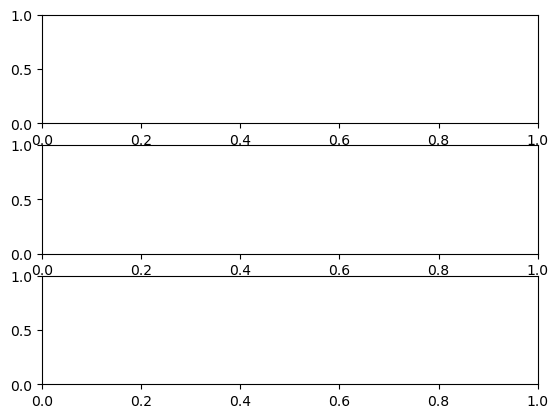

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3)

x_vals = []
for i, each in enumerate(denoised_data[0]):
    if i == 0:
        start_val = 0
    else:
        start_val = x_vals[-1][-1]
    x_vals.append(np.arange(start_val, start_val + len(each)))

for i, each in enumerate(denoised_data[0]):
    ax[i].plot(x_vals[i], each)